In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geoplot as gplt
import shapefile
import osr
import dbf
import requests
import io

from urllib.request import urlopen
from zipfile import ZipFile
from shapely.geometry import shape, Point, Polygon


%matplotlib inline

In [2]:
## All counties
allcounties = ZipFile('/home/jinli/PycharmProjects/tl_2010_us_county10(NEW).zip', 'r')

filenames_ac = [y for y in sorted(allcounties.namelist())
                 for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]

dbf_ac, prj_ac, shp_ac, shx_ac = [io.BytesIO(allcounties.read(filename)) for filename in filenames_ac]

r_ac = shapefile.Reader(shp=shp_ac, shx=shx_ac, dbf=dbf_ac)
## r_ac.numRecords   ### 3221


attributes, geometry = [], []

field_names = [field[0] for field in r_ac.fields[1:]]

for row in r_ac.shapeRecords():
    geometry.append(shape(row.shape.__geo_interface__))
    attributes.append(dict(zip(field_names,row.record)))
    
prj = io.TextIOWrapper(prj_ac, encoding='utf-8')
proj4 = osr.SpatialReference(prj.read()).ExportToProj4()

gdf_ac = gpd.GeoDataFrame(data=attributes, geometry=geometry, crs=proj4)
gdf_ac.sort_values(by =['STATEFP10', 'COUNTYFP10'], inplace=True)
gdf_ac.reset_index(drop=True, inplace=True)
gdf_ac[['INTPTLON10', 'INTPTLAT10']] = gdf_ac[['INTPTLON10', 'INTPTLAT10']].apply(pd.to_numeric)

gdf_ac = gdf_ac[(gdf_ac.STATEFP10 != '02') & (gdf_ac.STATEFP10 != '72') & (gdf_ac.STATEFP10 != '15')]

In [3]:
## All states
allstates = ZipFile('/home/jinli/PycharmProjects/tl_2010_us_state10.zip', 'r')

filenames_as = [y for y in sorted(allstates.namelist())
                for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]

dbf_as, prj_as, shp_as, shx_as = [io.BytesIO(allstates.read(filename)) for filename in filenames_as]

r_as = shapefile.Reader(shp=shp_as, shx=shx_as, dbf=dbf_as)

attributes, geometry = [], []

field_names = [field[0] for field in r_as.fields[1:]]
for row in r_as.shapeRecords():
    geometry.append(shape(row.shape.__geo_interface__))
    attributes.append(dict(zip(field_names,row.record)))
    
prj = io.TextIOWrapper(prj_as, encoding='utf-8')
proj4 = osr.SpatialReference(prj.read()).ExportToProj4()

gdf_as = gpd.GeoDataFrame(data=attributes, geometry=geometry, crs=proj4)
gdf_as = gdf_as[~gdf_as['STATEFP10'].isin(['02', '72', '15'])]
gdf_as.sort_values(by ='STATEFP10', ignore_index=True, inplace=True)

In [4]:
laus = pd.read_csv('LAUS_COUNTY_QUARTERLY_UNEMPLOYMENT.csv')

width = 5
laus['id']= laus['id'].astype(str) 
laus['id']= laus['id'].str.zfill(width)

cp_list = laus.id.tolist()
cp_list = list(set(cp_list)) ## remove duplicates
cp_list = [e for e in cp_list if e not in ('06001', '06041', '06081','06075')]

gdf_cp = gdf_ac[gdf_ac['GEOID10'].isin(cp_list)]

(-127.7471505, -63.98726749999998, 23.146905499999995, 50.63376050000001)

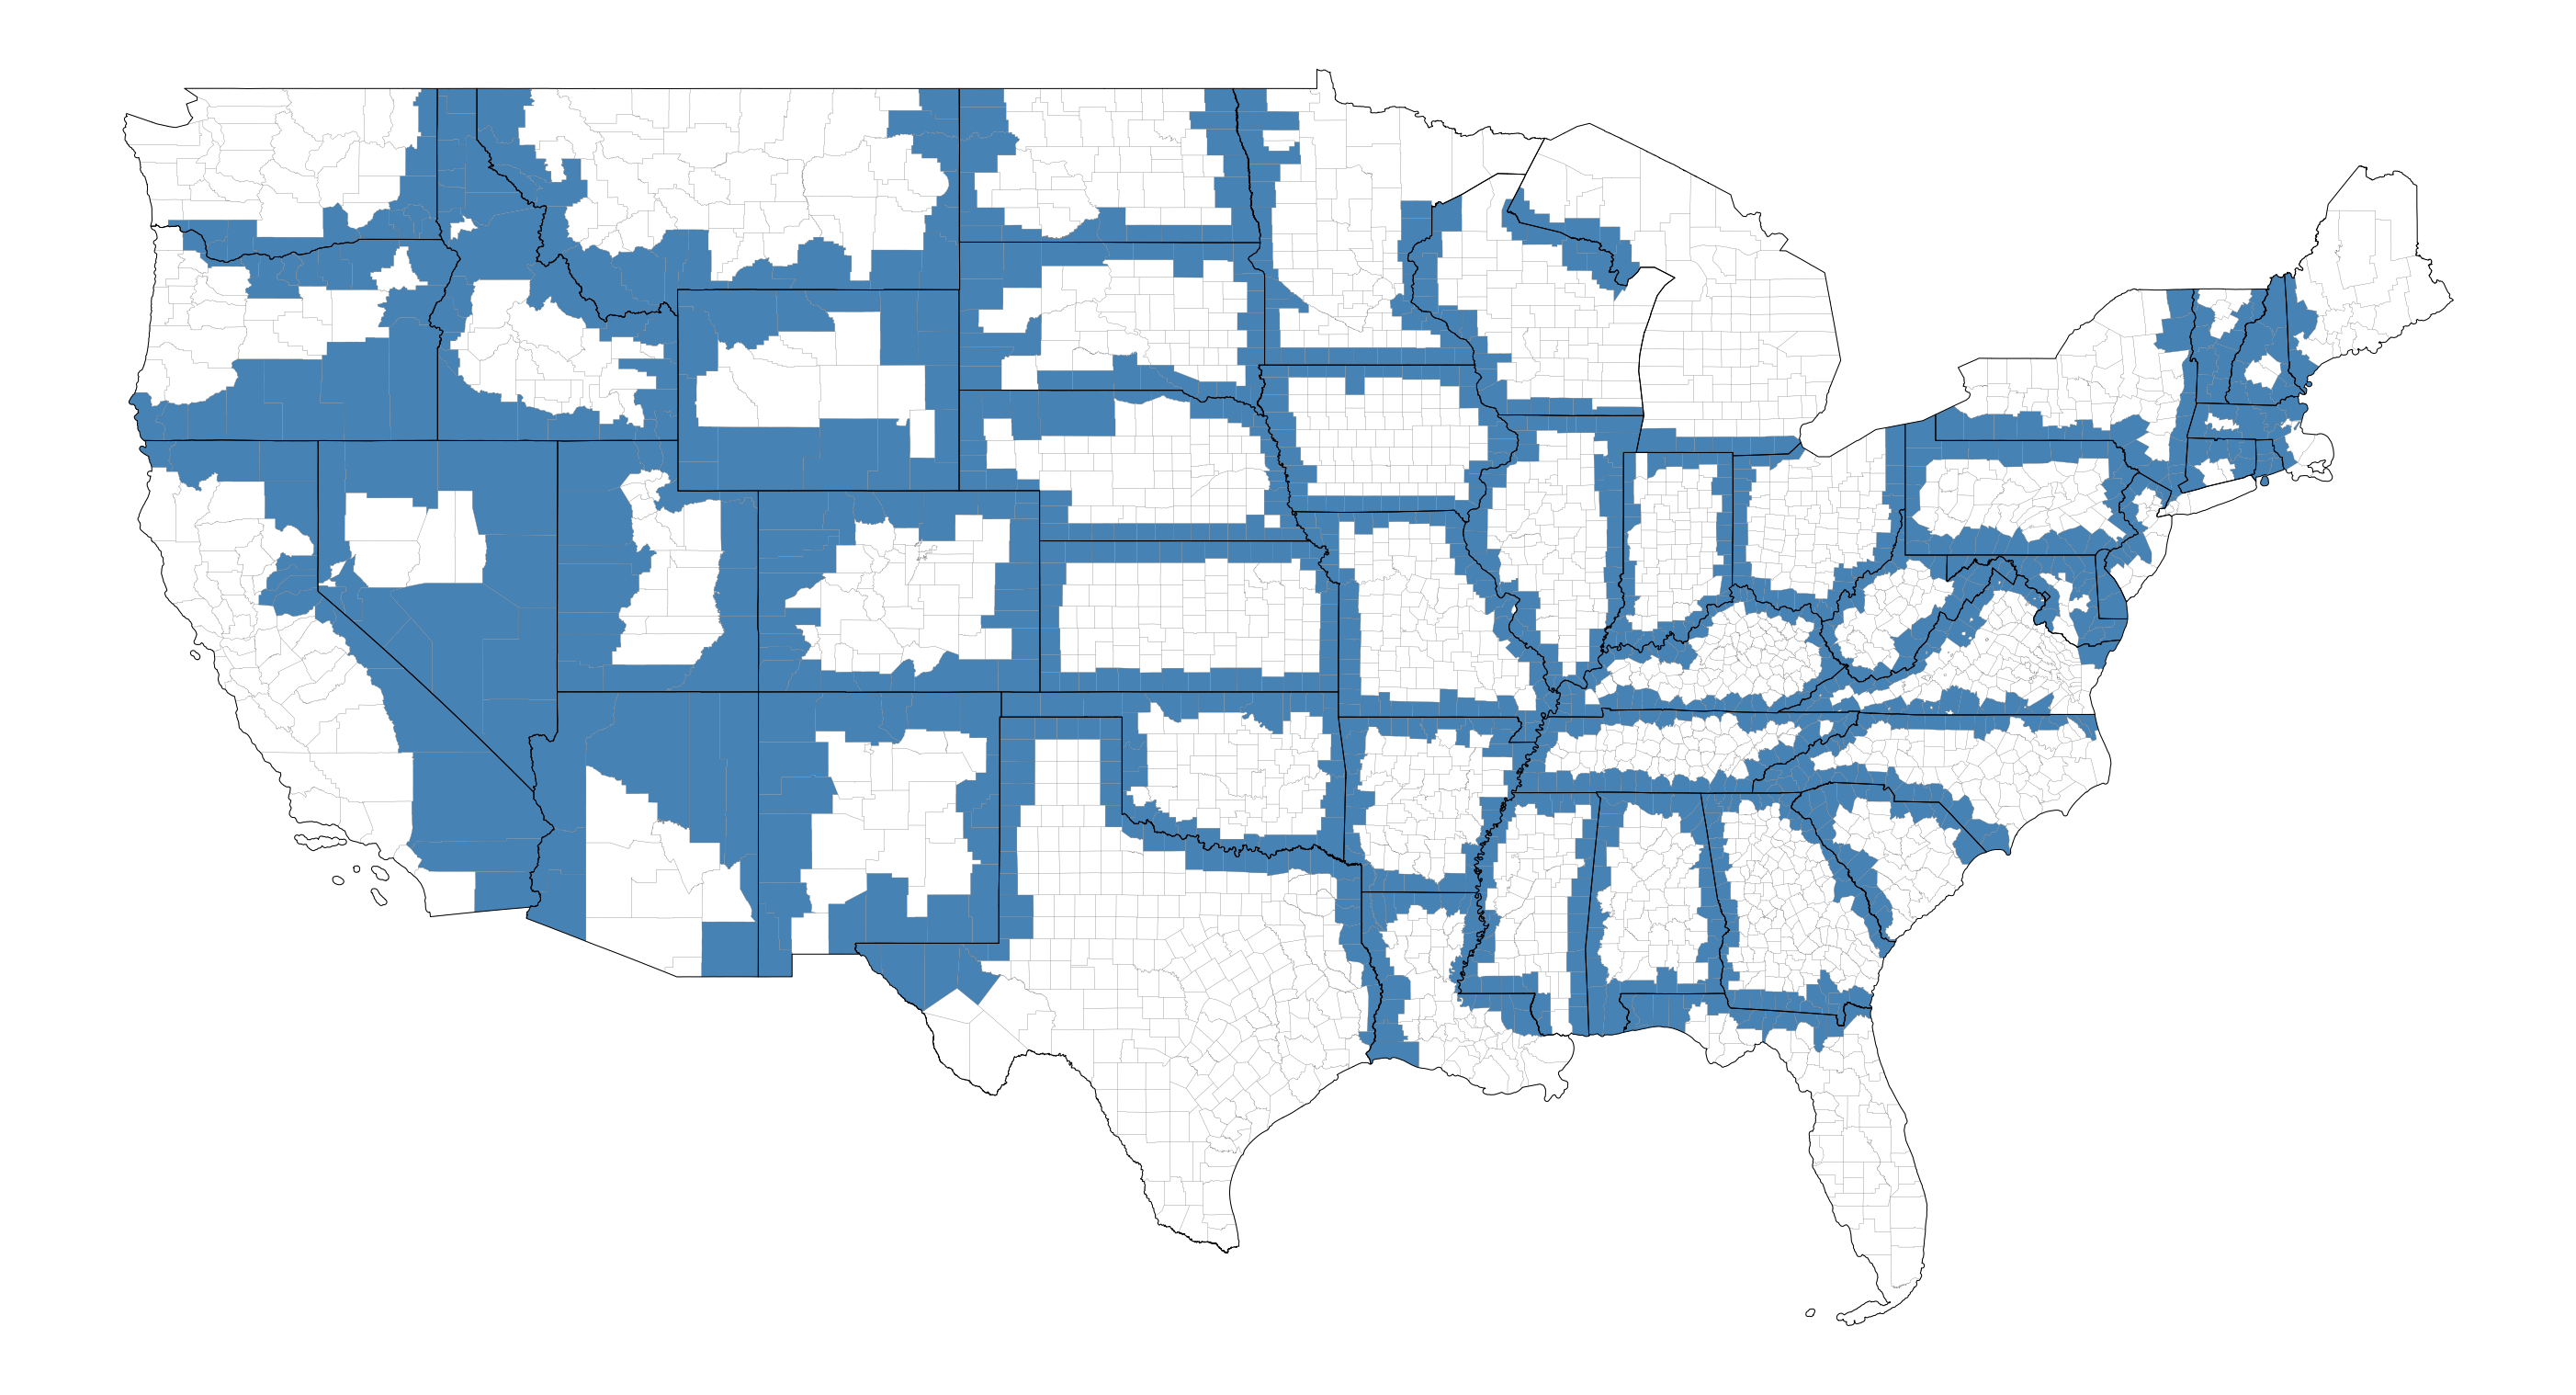

In [5]:
fig, ax = plt.subplots(figsize=(50,50))
gdf_cp.plot(ax=ax, color='steelblue', edgecolor='none')
gdf_ac.plot(ax=ax, facecolor='none', linewidth=0.2, edgecolor='grey')
gdf_as.plot(ax=ax, facecolor='none', linewidth=1, edgecolor='black')
ax.axis('off')

In [6]:
## Read Shapefile data(blocks in  Alabama(01))
s01_blocks = ZipFile('/home/jinli/PycharmProjects/tl_2010_01_tabblock10.zip', 'r') 

filenames_s01 = [y for y in sorted(s01_blocks.namelist())
                 for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]

dbf_s01, prj_s01, shp_s01, shx_s01 = [io.BytesIO(s01_blocks.read(filename)) for filename in filenames_s01]

r_s01 = shapefile.Reader(shp=shp_s01, shx=shx_s01, dbf=dbf_s01)

## Generate geodataframe with population weighted centroids
attributes_s01, geometry_s01 = [], []

field_names = [field[0] for field in r_s01.fields[1:]]

for row in r_s01.shapeRecords():
    geometry_s01.append(shape(row.shape.__geo_interface__))
    attributes_s01.append(dict(zip(field_names,row.record)))
    
prj = io.TextIOWrapper(prj_s01, encoding='utf-8')
proj4 = osr.SpatialReference(prj.read()).ExportToProj4()

gdf_s01 = gpd.GeoDataFrame(data=attributes_s01, geometry=geometry_s01, crs=proj4)
gdf_s01[['INTPTLON10', 'INTPTLAT10']] = gdf_s01[['INTPTLON10', 'INTPTLAT10']].apply(pd.to_numeric)
gdf_s01.sort_values(['COUNTYFP10', 'BLOCKCE10', 'TRACTCE10'], ascending=[True, True, True], inplace=True)
gdf_s01.reset_index(drop=True, inplace=True)

pop_s01 = pd.read_csv('/home/jinli/PycharmProjects/DECENNIALSF12010.P1_data_with_overlays_01.csv')
pop_s01['GEOID10'] = pop_s01['id'].map(lambda x: x[9:])
### cols = pop_s01.columns.tolist()   ## ['id', 'Geographic Area Name', 'Total', 'GEOID10']
pop_s01 = pop_s01[['id', 'Geographic Area Name', 'GEOID10', 'Total']]

geodata_s01 = pd.merge(gdf_s01, pop_s01, on='GEOID10')
geodata_s01 = geodata_s01[['STATEFP10', 'COUNTYFP10', 'GEOID10', 'BLOCKCE10', 'geometry', 
                           'Total', 'INTPTLON10', 'INTPTLAT10', 'Geographic Area Name']]
geodata_s01['count'] = 1

geodata_s01['LON*POP'] = geodata_s01['Total']*geodata_s01['INTPTLON10']
geodata_s01['LAT*POP'] = geodata_s01['Total']*geodata_s01['INTPTLAT10']

### Sum up blocks' data by counties within state
s01_ac = geodata_s01.groupby(['STATEFP10', 'COUNTYFP10'])['Total', 'LON*POP', 'LAT*POP', 'count', 
                                                          'INTPTLON10', 'INTPTLAT10'].sum().reset_index()
### Calculate weighted/unweighted centroid 
s01_ac['w.LON'] = s01_ac['LON*POP']/s01_ac['Total']
s01_ac['w.LAT'] = s01_ac['LAT*POP']/s01_ac['Total']
s01_ac['LON'] = s01_ac['INTPTLON10']/s01_ac['count']
s01_ac['LAT'] = s01_ac['INTPTLAT10']/s01_ac['count']
s01_ac = s01_ac[['STATEFP10', 'COUNTYFP10', 'Total', 'w.LON', 'w.LAT', 'count', 'LON', 'LAT']]

u_s01 = s01_ac[['STATEFP10', 'COUNTYFP10', 'LON', 'LAT']]
w_s01 = s01_ac[['STATEFP10', 'COUNTYFP10', 'w.LON', 'w.LAT']].rename({'w.LON': 'LON', 
                                                                      'w.LAT': 'LAT'}, axis=1)

w_s01['Weighted'] = 1
u_s01['Weighted'] = 0

s01_ac = pd.concat([w_s01, u_s01]).sort_values(by='COUNTYFP10', ascending=True).reset_index(drop=True)

### Creat new geodataframe with centroid points transfromed to geometry
geometry_s01 = [Point(xy) for xy in zip(s01_ac['LON'], s01_ac['LAT'])]
cent_s01 = gpd.GeoDataFrame(s01_ac, geometry=geometry_s01)

cent_s01['GEOID10'] = cent_s01['STATEFP10'] + cent_s01['COUNTYFP10']
GEOID10 = cent_s01['GEOID10']
cent_s01.drop(labels=['GEOID10'], axis=1, inplace = True)
cent_s01.insert(0, 'GEOID10', GEOID10)

/home/jinli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/home/jinli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
## Read Shapefile data(blocks in Florida(12))
s12_blocks = ZipFile('/home/jinli/PycharmProjects/tl_2010_12_tabblock10.zip', 'r') 

filenames_s12 = [y for y in sorted(s12_blocks.namelist())
                 for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]

dbf_s12, prj_s12, shp_s12, shx_s12 = [io.BytesIO(s12_blocks.read(filename)) for filename in filenames_s12]

r_s12 = shapefile.Reader(shp=shp_s12, shx=shx_s12, dbf=dbf_s12)

## Generate geodataframe with population weighted centroids
attributes_s12, geometry_s12 = [], []

field_names = [field[0] for field in r_s12.fields[1:]]

for row in r_s12.shapeRecords():
    geometry_s12.append(shape(row.shape.__geo_interface__))
    attributes_s12.append(dict(zip(field_names,row.record)))
    
prj = io.TextIOWrapper(prj_s12, encoding='utf-8')
proj4 = osr.SpatialReference(prj.read()).ExportToProj4()

gdf_s12 = gpd.GeoDataFrame(data=attributes_s12, geometry=geometry_s12, crs=proj4)
gdf_s12[['INTPTLON10', 'INTPTLAT10']] = gdf_s12[['INTPTLON10', 'INTPTLAT10']].apply(pd.to_numeric)
gdf_s12.sort_values(['COUNTYFP10', 'BLOCKCE10', 'TRACTCE10'], ascending=[True, True, True], inplace=True)
gdf_s12.reset_index(drop=True, inplace=True)

pop_s12 = pd.read_csv('/home/jinli/PycharmProjects/DECENNIALSF12010.P1_data_with_overlays_12.csv')
pop_s12['GEOID10'] = pop_s12['id'].map(lambda x: x[9:])
### cols = pop_s12.columns.tolist()   ## ['id', 'Geographic Area Name', 'Total', 'GEOID10']
pop_s12 = pop_s12[['id', 'Geographic Area Name', 'GEOID10', 'Total']]

geodata_s12 = pd.merge(gdf_s12, pop_s12, on='GEOID10')
geodata_s12 = geodata_s12[['STATEFP10', 'COUNTYFP10', 'GEOID10', 'BLOCKCE10', 'geometry', 
                           'Total', 'INTPTLON10', 'INTPTLAT10', 'Geographic Area Name']]
geodata_s12['count'] = 1

geodata_s12['LON*POP'] = geodata_s12['Total']*geodata_s12['INTPTLON10']
geodata_s12['LAT*POP'] = geodata_s12['Total']*geodata_s12['INTPTLAT10']

### Sum up blocks' data by counties within state
s12_ac = geodata_s12.groupby(['STATEFP10', 'COUNTYFP10'])['Total', 'LON*POP', 'LAT*POP', 'count', 
                                                          'INTPTLON10', 'INTPTLAT10'].sum().reset_index()
### Calculate weighted/unweighted centroid 
s12_ac['w.LON'] = s12_ac['LON*POP']/s12_ac['Total']
s12_ac['w.LAT'] = s12_ac['LAT*POP']/s12_ac['Total']
s12_ac['LON'] = s12_ac['INTPTLON10']/s12_ac['count']
s12_ac['LAT'] = s12_ac['INTPTLAT10']/s12_ac['count']
s12_ac = s12_ac[['STATEFP10', 'COUNTYFP10', 'Total', 'w.LON', 'w.LAT', 'count', 'LON', 'LAT']]

u_s12 = s12_ac[['STATEFP10', 'COUNTYFP10', 'LON', 'LAT']]
w_s12 = s12_ac[['STATEFP10', 'COUNTYFP10', 'w.LON', 'w.LAT']].rename({'w.LON': 'LON', 
                                                                      'w.LAT': 'LAT'}, axis=1)

w_s12['Weighted'] = 1
u_s12['Weighted'] = 0

s12_ac = pd.concat([w_s12, u_s12]).sort_values(by='COUNTYFP10', ascending=True).reset_index(drop=True)

### Creat new geodataframe with centroid points transfromed to geometry
geometry_s12 = [Point(xy) for xy in zip(s12_ac['LON'], s12_ac['LAT'])]
cent_s12 = gpd.GeoDataFrame(s12_ac, geometry=geometry_s12)

cent_s12['GEOID10'] = cent_s12['STATEFP10'] + cent_s12['COUNTYFP10']
GEOID10 = cent_s12['GEOID10']
cent_s12.drop(labels=['GEOID10'], axis=1, inplace = True)
cent_s12.insert(0, 'GEOID10', GEOID10)

/home/jinli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/home/jinli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
centroid_frames = [cent_s01, cent_s12]
centroids = pd.concat(centroid_frames)

block_frames = [gdf_s01, gdf_s12]
blocks = pd.concat(block_frames) 

(-88.89817304999998,
 -79.54935994999998,
 23.865721999999998,
 35.538613999999995)

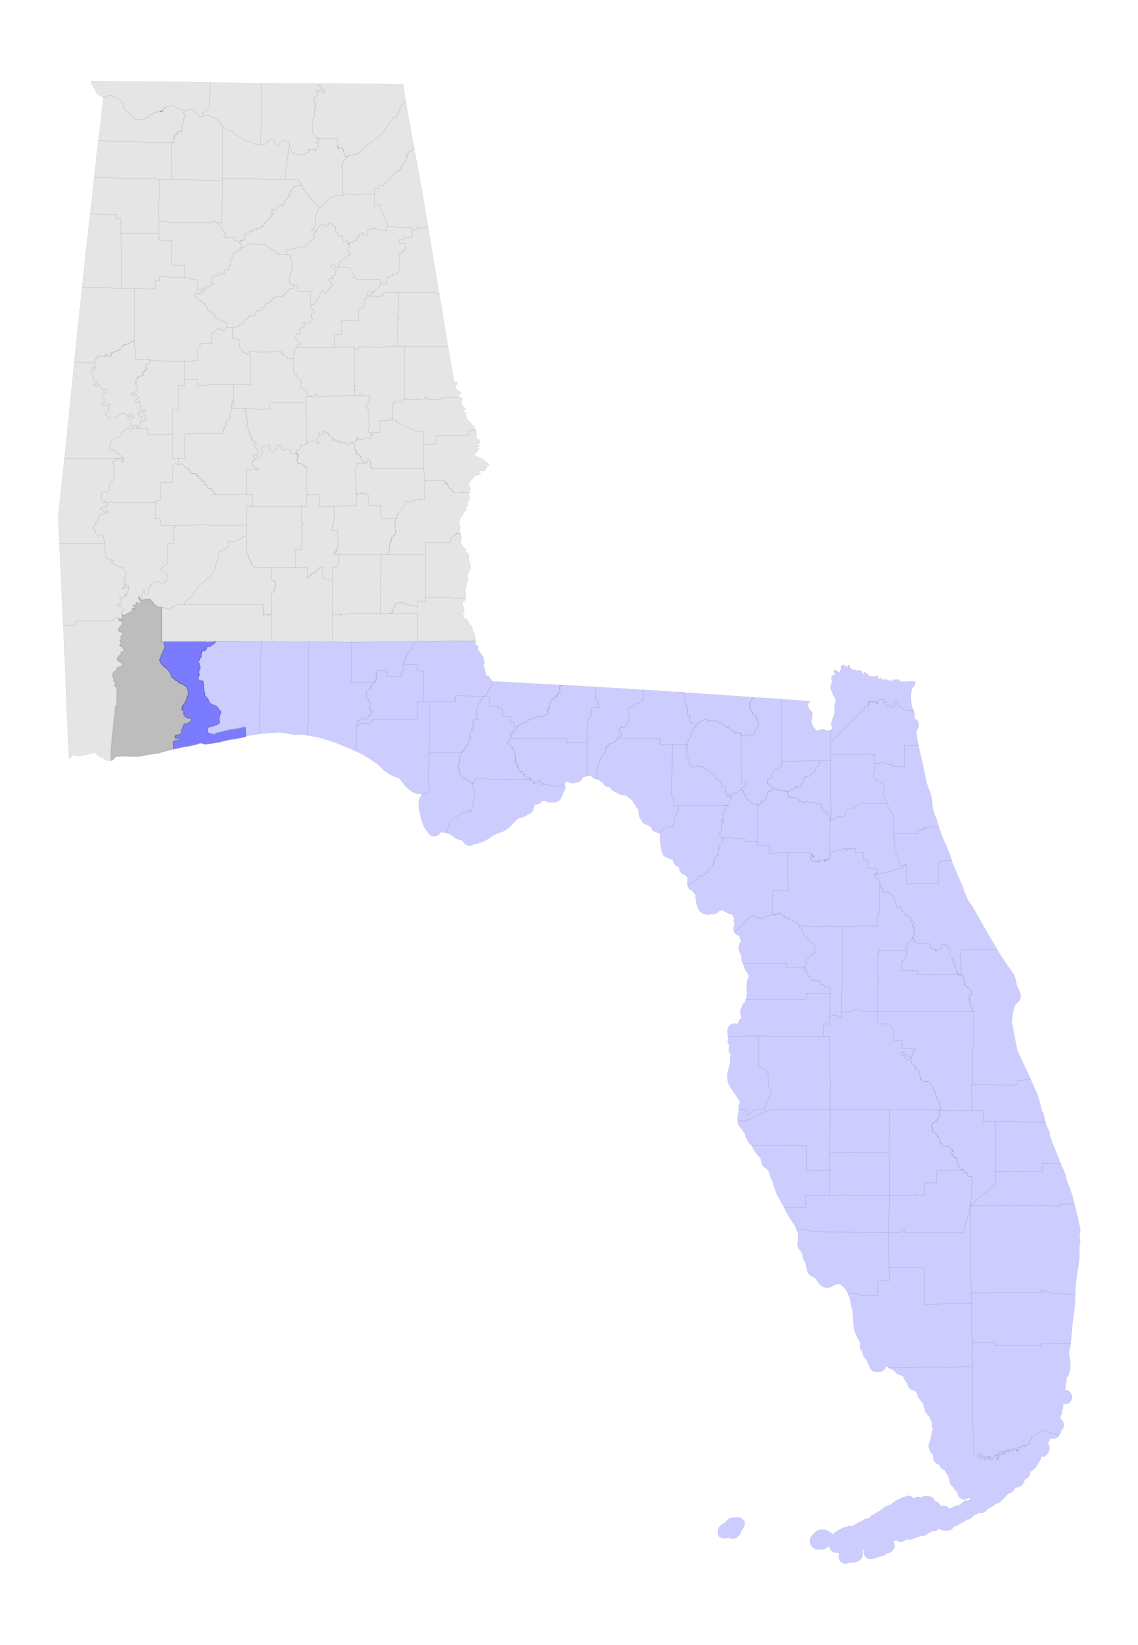

In [9]:
## States plot of Alabama(01) and Florida(12)

fig1, ax = plt.subplots(figsize=(30,30))

gdf_ac[gdf_ac.STATEFP10=='01'].plot(ax=ax, alpha=0.2, color='grey', linewidth=0.2, edgecolor='black')
gdf_ac[(gdf_ac.STATEFP10=='01') & (gdf_ac.COUNTYFP10 == '003')].plot(ax=ax, alpha=0.4, 
                                                                     color='grey', linewidth=0.2, edgecolor='black')
gdf_ac[gdf_ac.STATEFP10=='12'].plot(ax=ax, alpha=0.2, color='blue', linewidth=0.2, edgecolor='black')
gdf_ac[(gdf_ac.STATEFP10=='12') & (gdf_ac.COUNTYFP10 == '033')].plot(ax=ax, alpha=0.4, 
                                                                     color='blue', linewidth=0.2, edgecolor='black')
ax.axis('off')

In [10]:
## County Boundary Dataframe: cbd
cbd = gdf_ac[['STATEFP10', 'COUNTYFP10', 'GEOID10', 'geometry']]
c01003 = cbd[cbd.GEOID10=='01003'].geometry
c12033 = cbd[cbd.GEOID10=='12033'].geometry

c01003.reset_index(inplace=True, drop=True)
c12033.reset_index(inplace=True, drop=True)

## County Boundary Intersection: cbi
c01003.touches(c12033) ##     True   ## dtype: bool
cbi = c01003.intersection(c12033) ##     MULTILINESTRING ((-87.59883 30.99745, -87.5988...
### type(cbi) ### geopandas.geoseries.GeoSeries

(-88.09334409999998,
 -86.86057190000001,
 30.087938199999996,
 31.377639800000004)

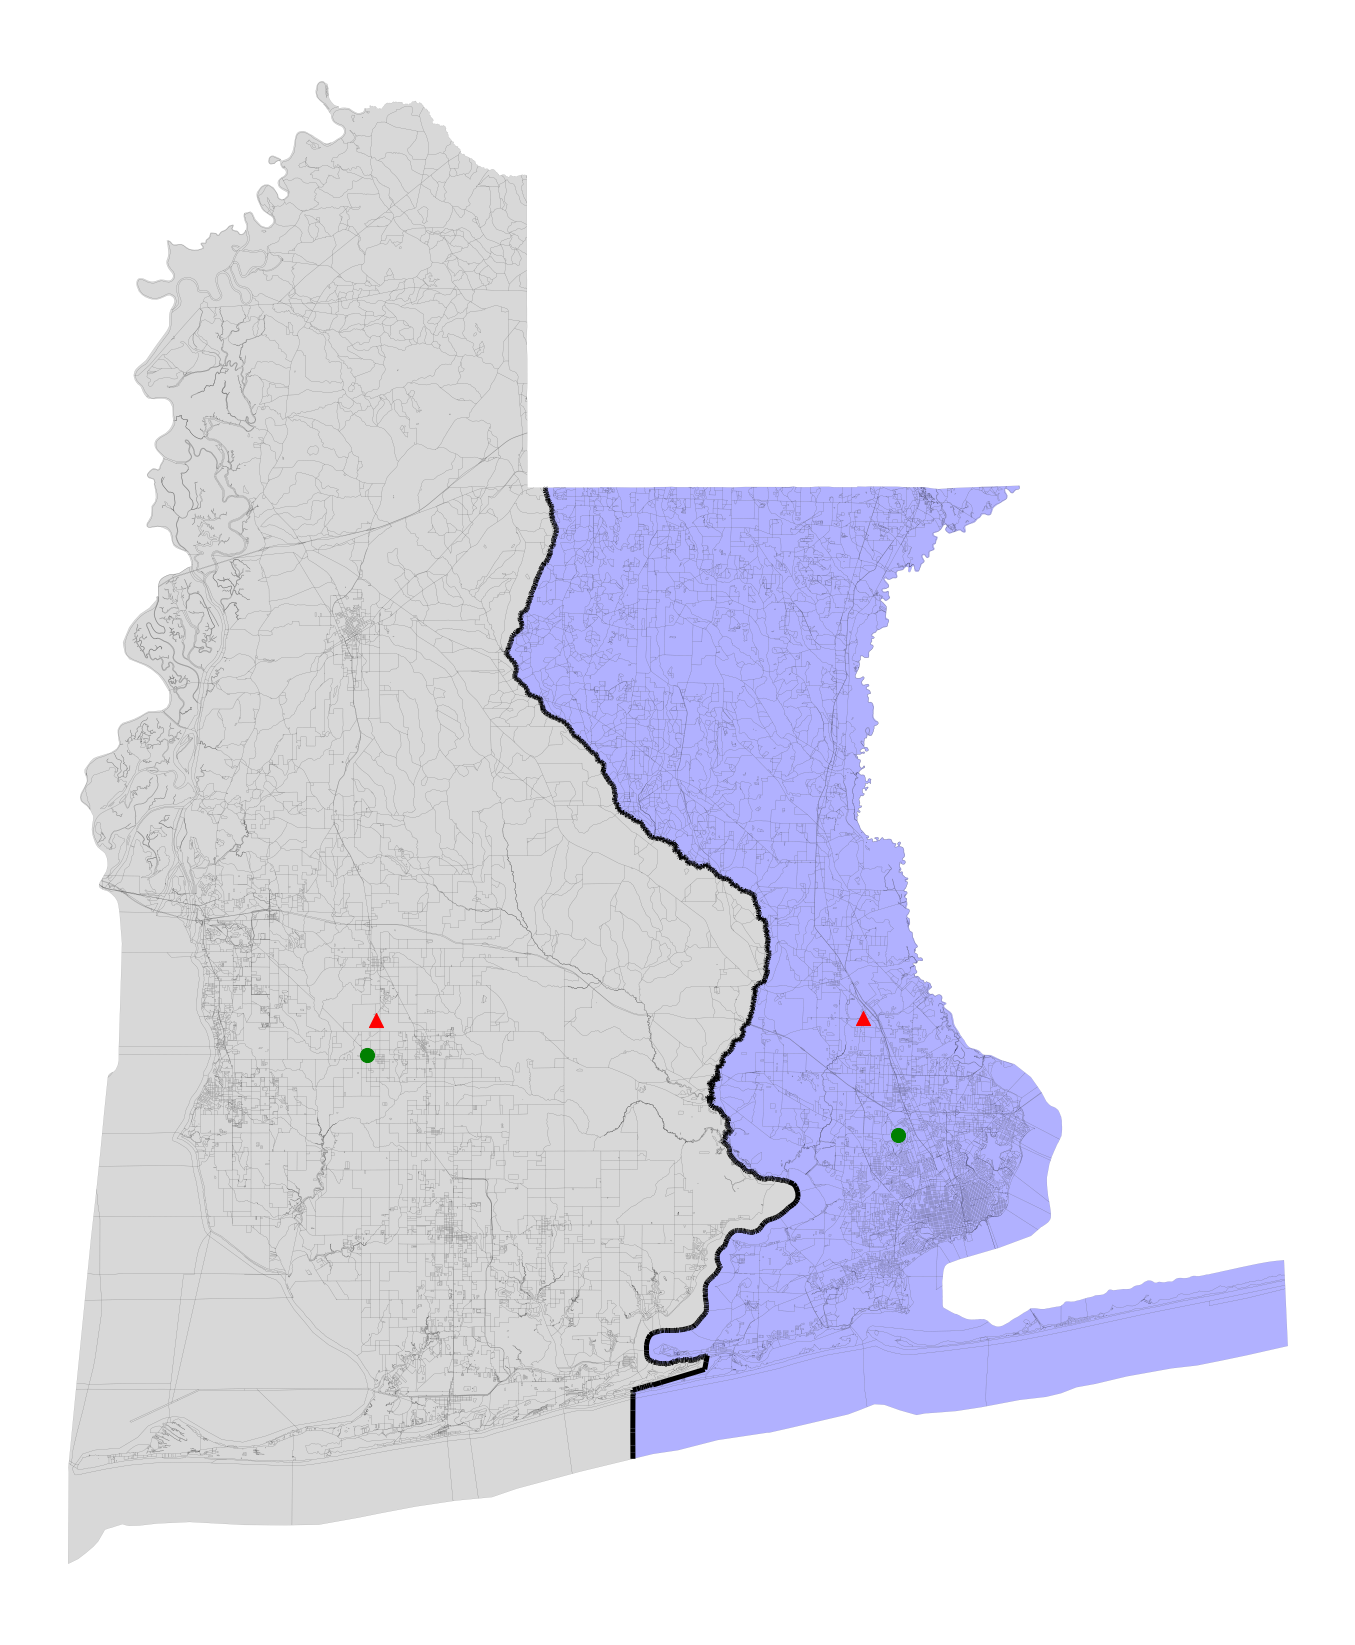

In [11]:
fig2, ax = plt.subplots(figsize=(30,30))

blocks[(blocks.STATEFP10=='01') & (blocks.COUNTYFP10=='003')].plot(ax=ax, alpha=0.3, color='grey', linewidth=0.2, edgecolor='black')
blocks[(blocks.STATEFP10=='12') & (blocks.COUNTYFP10=='033')].plot(ax=ax, alpha=0.3, color='blue', linewidth=0.2, edgecolor='black')

centroids[(centroids.Weighted==1) & (centroids.GEOID10=='01003')].plot(ax=ax, markersize=200, color='green', marker='o')
centroids[(centroids.Weighted==1) & (centroids.GEOID10=='12033')].plot(ax=ax, markersize=200, color='green', marker='o')
centroids[(centroids.Weighted==0) & (centroids.GEOID10=='01003')].plot(ax=ax, markersize=200, color='red', marker='^')
centroids[(centroids.Weighted==0) & (centroids.GEOID10=='12033')].plot(ax=ax, markersize=200, color='red', marker='^')

cbi.plot(ax=ax, color='black', linewidth=5)
ax.axis('off')

In [12]:
state_geo = gdf_as[['GEOID10', 'NAME10', 'geometry']]

benefits = pd.read_csv('Maximum_Benefit_Duration.csv')

width = 2
benefits["state_id"]= benefits["state_id"].astype(str) 
benefits["state_id"]= benefits["state_id"].str.zfill(width) 

benefits08q4 = benefits[benefits.variable == '2008Q4']
benefits09q4 = benefits[benefits.variable == '2009Q4']
benefits11q4 = benefits[benefits.variable == '2011Q4']
benefits12q4 = benefits[benefits.variable == '2012Q4']

df08q4 = pd.merge(state_geo, benefits08q4, how='left', left_on='GEOID10', right_on='state_id')
df09q4 = pd.merge(state_geo, benefits09q4, how='left', left_on='GEOID10', right_on='state_id')
df11q4 = pd.merge(state_geo, benefits11q4, how='left', left_on='GEOID10', right_on='state_id')
df12q4 = pd.merge(state_geo, benefits12q4, how='left', left_on='GEOID10', right_on='state_id')

df08q4 = df08q4[['GEOID10', 'NAME10', 'value', 'geometry']]
df09q4 = df09q4[['GEOID10', 'NAME10', 'value', 'geometry']]
df11q4 = df11q4[['GEOID10', 'NAME10', 'value', 'geometry']]
df12q4 = df12q4[['GEOID10', 'NAME10', 'value', 'geometry']]

Text(0.5, 1, 'state-level maximum benefit duration in 2008Q4 ')

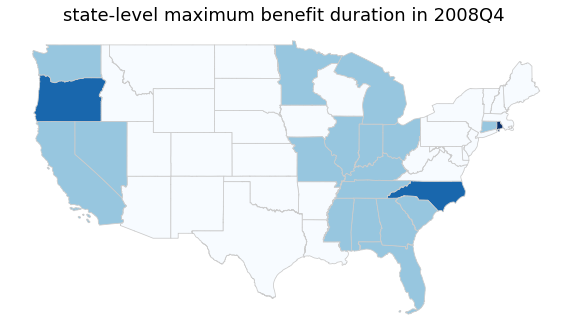

In [13]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'value'
# set the range for the choropleth
vmin, vmax = 26, 99
# create figure and axes for Matplotlib
fig3_1, ax = plt.subplots(1, figsize=(10, 6))

# create map
df08q4.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
# remove the axis
ax.axis('off')
# add a title
ax.set_title('state-level maximum benefit duration in 2008Q4 ', fontdict={'fontsize': '18', 'fontweight' : '1'})

Text(0.5, 1, 'state-level maximum benefit duration in 2009Q4 ')

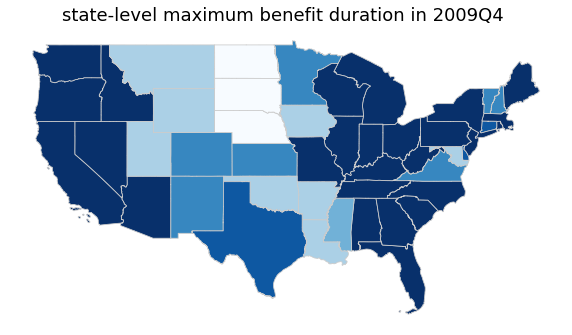

In [14]:
fig3_2, ax = plt.subplots(1, figsize=(10, 6))
df09q4.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('state-level maximum benefit duration in 2009Q4 ', fontdict={'fontsize': '18', 'fontweight' : '1'})

Text(0.5, 1, 'state-level maximum benefit duration in 2011Q4 ')

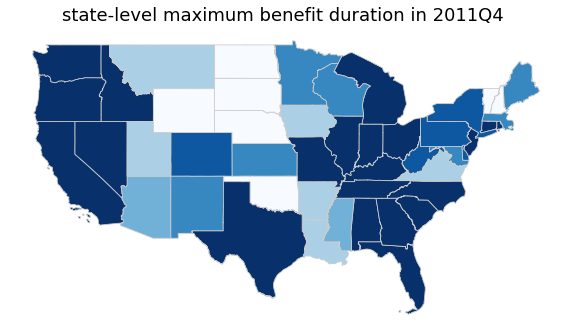

In [15]:
fig3_3, ax = plt.subplots(1, figsize=(10, 6))
df11q4.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('state-level maximum benefit duration in 2011Q4 ', fontdict={'fontsize': '18', 'fontweight' : '1'})

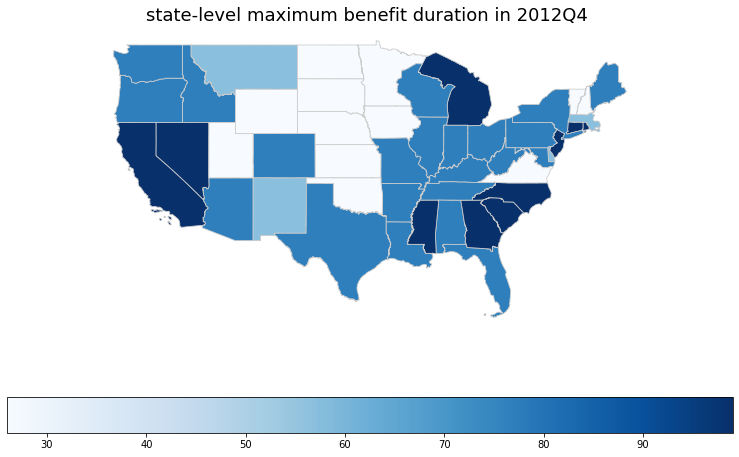

In [17]:
fig3_4, ax = plt.subplots(1, figsize=(13, 8))
df12q4.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('state-level maximum benefit duration in 2012Q4 ', fontdict={'fontsize': '18', 'fontweight' : '1'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig3_4.colorbar(sm, orientation='horizontal')